# Optimization equation : Minimum Volatility

$$
\begin{aligned}
    &\underset{\mathbf{w}}{\text{minimize}} & & \mathbf{w}^T \Sigma \mathbf{w} \\
    &\text{subject to} & & \sum_{j=1}^{n} w_j = 1 \\
    & & & w_j \geq 0, \quad j = 1, \ldots, N \\
    & & & w_j \leq 0.10, \quad j = 1, \ldots, N \\
    & & & w_j \geq 0.02, \quad j = 1, \ldots, N
\end{aligned}
$$

In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
from pypfopt.expected_returns import mean_historical_return, ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib.pyplot as plt
import seaborn as sns

# Conversion of our tickers' currencies into euro

In [29]:
# Ticker data and number of shares held
portfolio = {
    "SAN.PA": 20,   # Sanofi
    "VIV.PA": 12,   # Vivendi
    "RMS.PA": 7,    # Hermès
    "BN.PA": 5,     # Danone
    "2B78.DE": 68,
    "AAPL": 15,
    "AED.BR": 13,
    "BFIT.AS": 17,
    "BX": 5,
    "EVO.ST": 4,
    "ENPH": 5,
    "IGLN.L": 43,
    "IESE.AS": 17,
    "IQQH.DE": 58,
    "MC.PA": 3,
    "MRK": 13,
    "MSFT": 8,
    "NESN.SW": 5,
    "OGN": 1,
    "RCF.F": 5,
}


tickers = list(portfolio.keys())
shares = np.array(list(portfolio.values()))

# Download historical data
start_date = "2024-06-04"
end_date = "2024-12-05"

data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()

tickers_curr = {"SAN.PA": "EUR", "VIV.PA": "EUR", "RMS.PA": "EUR", "BN.PA": "EUR", "2B78.DE": "EUR", 
                "AAPL": "USD", "AED.BR": "EUR", "BFIT.AS": "EUR", 
                "BX": "USD", "EVO.ST": "SEK", "ENPH": "USD", "IGLN.L": "GBP",
                "IESE.AS": "EUR", "IQQH.DE": "EUR", "MC.PA": "EUR", "MRK": "USD",
                "MSFT": "USD", "NESN.SW": "CHF", "OGN": "USD", "RCF.F": "EUR",
                }



currencies = set(tickers_curr.values())
fx_tickers = [f"{curr}EUR=X" for curr in currencies if curr != "EUR"] # created a list of forex tickers to download the conversion rates

fx_rates = yf.download(fx_tickers, start=start_date, end=end_date)['Close']

fx_rates['EUR'] = 1.0  
fx_rates = fx_rates.ffill().bfill()

fx_rates.columns = [col.replace('=X', '').replace('EUR', '') for col in fx_rates.columns]


for ticker, currency in tickers_curr.items():
    if currency != "EUR":
        conversion_rate = fx_rates[currency]
        data[ticker] = data[ticker] * conversion_rate
    

last_prices = data.iloc[-1]
print(last_prices)

# Total portfolio value
total_portfolio_value = np.sum(last_prices * shares)
print("\n\n")
print(f"Total portfolio value: {total_portfolio_value:.2f} EUR")

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  4 of 4 completed

Ticker
2B78.DE       7.538000
AAPL        231.199704
AED.BR       57.950001
BFIT.AS      20.920000
BN.PA        64.739998
BX          176.484697
ENPH         69.566369
EVO.ST       82.048612
IESE.AS      70.230003
IGLN.L       62.178030
IQQH.DE       6.601000
MC.PA       610.200012
MRK          96.443419
MSFT        416.161393
NESN.SW      81.952455
OGN          14.613503
RCF.F        85.739998
RMS.PA     2200.000000
SAN.PA       91.349998
VIV.PA        8.448000
Name: 2024-12-04 00:00:00+00:00, dtype: float64



Total portfolio value: 77687.90 EUR


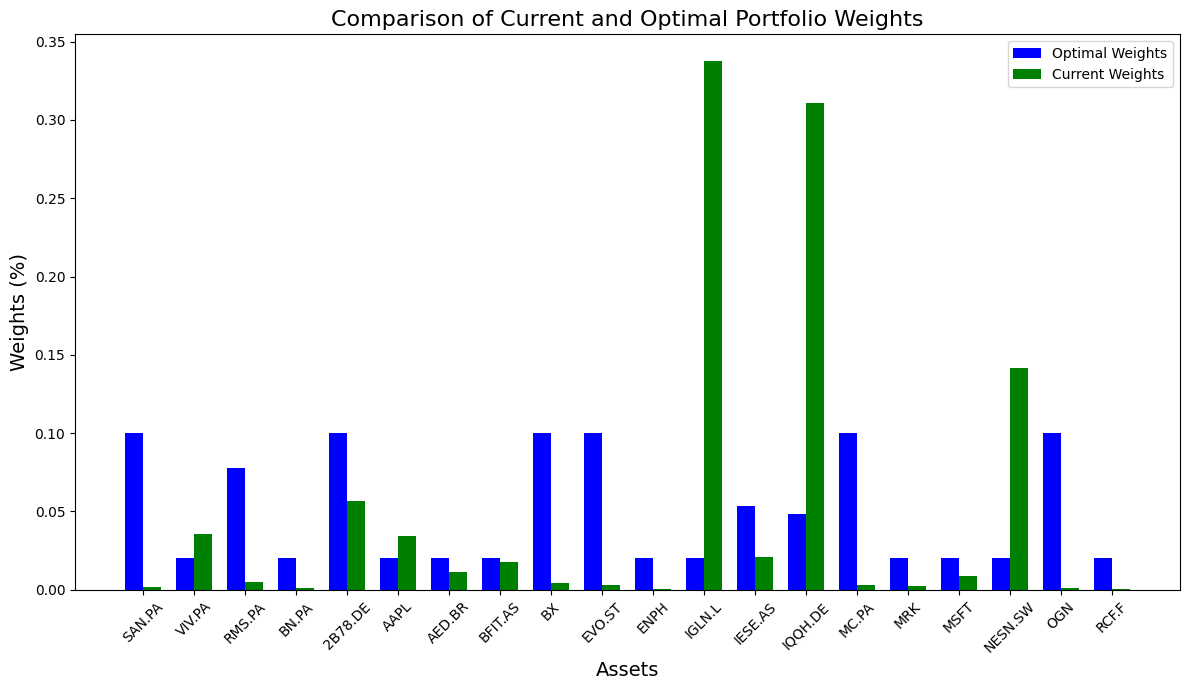

C:\Users\leoli\AppData\Local\Temp\ipykernel_24012\1537700942.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (assets_df['Volatility'][i], assets_df['Return'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


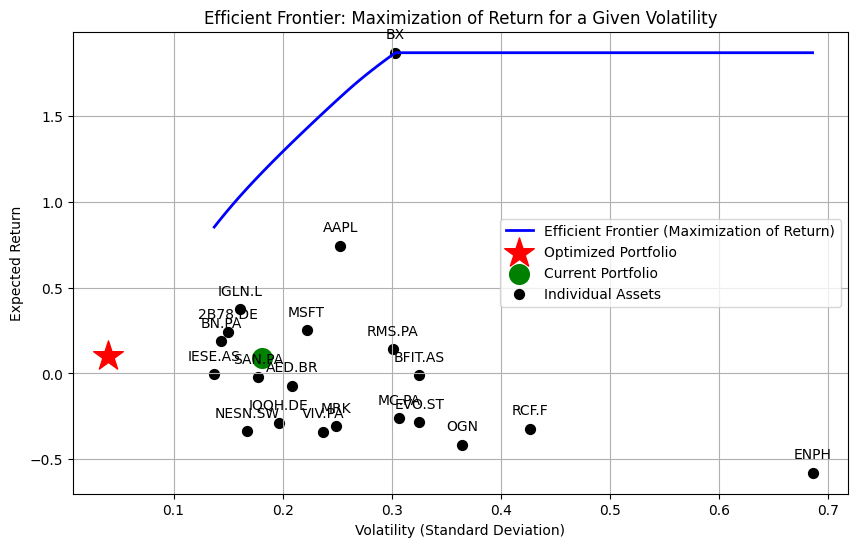

In [38]:

# Calculate the current weights in the portfolio
current_weights = (last_prices * shares) / np.sum(last_prices * shares)


# Calculate expected returns and covariance
mu = ema_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf(shrinkage_target='constant_correlation')

# Optimization for minimum volatility
ef = EfficientFrontier(mu, S)

# Add constraints: min 2% weight, max 10% weight
ef.add_constraint(lambda w: w >= 0.02)  # Min weight 2%
ef.add_constraint(lambda w: w <= 0.10)  # Max weight 10%

ef.min_volatility()
weights_optimal = ef.clean_weights()
volatility, expected_return, _ = ef.portfolio_performance()

# Prepare data for comparison
weights_comparison = pd.DataFrame({
    "Optimal Weights": weights_optimal.values(),
    "Current Weights": current_weights
})

# 
weights_comparison.index = tickers

# Visualization: Comparison of Current and Optimal Weights
plt.figure(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(weights_comparison))

plt.bar(index, weights_comparison['Optimal Weights'], bar_width, label='Optimal Weights', color='blue')
plt.bar(index + bar_width, weights_comparison['Current Weights'], bar_width, label='Current Weights', color='green')

plt.xlabel('Assets', fontsize=14)
plt.ylabel('Weights (%)', fontsize=14)
plt.title('Comparison of Current and Optimal Portfolio Weights', fontsize=16)
plt.xticks(index + bar_width / 2, weights_comparison.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the efficient frontier
min_volatility = np.sqrt(np.min(np.diag(S)))
max_volatility = np.sqrt(np.max(np.diag(S)))
volatility_targets = np.linspace(min_volatility, max_volatility, 100)
frontier_returns = []

for vol in volatility_targets:
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(target_volatility=vol)
    ret, vol, _ = ef.portfolio_performance(verbose=False)
    frontier_returns.append(ret)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(volatility_targets, frontier_returns, label='Efficient Frontier (Maximization of Return)', color='blue', linewidth=2)
plt.scatter(volatility, expected_return, marker='*', color='red', s=500, label='Optimized Portfolio')

# Calculate the current portfolio performance
expected_return_current = np.dot(current_weights, mu)
volatility_current = np.sqrt(np.dot(current_weights.T, np.dot(S, current_weights)))

plt.scatter(volatility_current, expected_return_current, marker='o', color='green', s=200, label='Current Portfolio')

# Add individual assets
assets_df = pd.DataFrame({'Return': mu, 'Volatility': np.sqrt(np.diag(S))})
plt.scatter(assets_df['Volatility'], assets_df['Return'], c='black', s=50, label='Individual Assets')
for i, txt in enumerate(assets_df.index):
    plt.annotate(txt, (assets_df['Volatility'][i], assets_df['Return'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title('Efficient Frontier: Maximization of Return for a Given Volatility')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.savefig('efficient_frontier.png')
plt.show()

# Calculate the number of shares to buy

Allocation in whole shares: {'2B78.DE': 1030, 'AAPL': 6, 'AED.BR': 104, 'BFIT.AS': 74, 'BN.PA': 119, 'BX': 8, 'ENPH': 22, 'EVO.ST': 18, 'IESE.AS': 110, 'IGLN.L': 124, 'IQQH.DE': 235, 'MC.PA': 2, 'MRK': 43, 'MSFT': 9, 'NESN.SW': 94, 'OGN': 106, 'RCF.F': 18, 'RMS.PA': 0, 'SAN.PA': 85, 'VIV.PA': 183}
Remaining resources: 2632.26 EUR


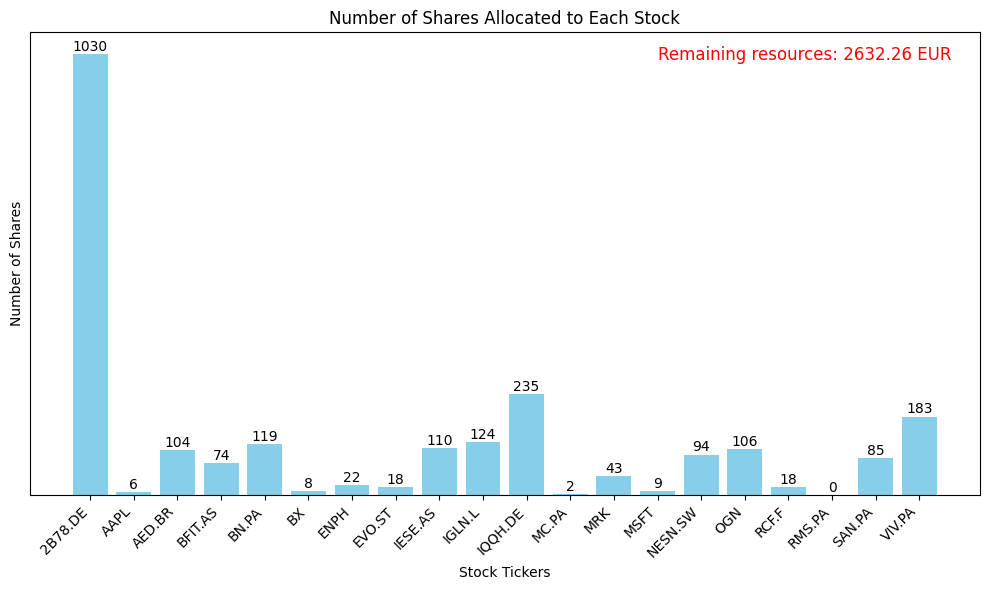

In [ ]:

# Allocate euros to each asset based on optimal weights
allocation_in_euros = {
    ticker: weight * total_portfolio_value
    for ticker, weight in weights_optimal.items()
}

# Calculate the number of whole shares to purchase for each asset
allocation_in_shares = {
    ticker: int(allocation_in_euros[ticker] // last_prices[ticker])
    for ticker in allocation_in_euros if allocation_in_euros[ticker] > 0
}

# Calculate the remaining resources after allocation
used_value = sum(allocation_in_shares[ticker] * last_prices[ticker] for ticker in allocation_in_shares)
leftover = total_portfolio_value - used_value

# Display the results
print("Allocation in whole shares:", allocation_in_shares)
print("Remaining resources:", round(leftover, 2), "EUR")

# Plotting the number of shares for each stock
plt.figure(figsize=(10, 6))
bars = plt.bar(allocation_in_shares.keys(), allocation_in_shares.values(), color='skyblue')

# Adding the number of shares on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5,  # Position the text slightly above the bar
             str(int(yval)), ha='center', va='bottom', fontsize=10)

# Removing the y-axis labels
plt.yticks([])

# Adding labels and title
plt.xlabel('Stock Tickers')
plt.ylabel('Number of Shares')
plt.title('Number of Shares Allocated to Each Stock')

# Add the remaining resources in the top right corner
plt.text(0.97, 0.97, f'Remaining resources: {round(leftover, 2)} EUR', 
         ha='right', va='top', fontsize=12, color='red', transform=plt.gca().transAxes)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [32]:
def plot_template(weights_dict_optimized, weights_dict_current, save_path='weights_comparison.png'):
    """
    Weights given as proportions, not percentages
    - weights_dict_optimized: dictionary of optimized weights, {asset: weight}.
    - weights_dict_current: dictionary of current weights, {asset: weight}.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    
    weights_dict_optimized = {k: round(v * 100, 2) for k, v in weights_dict_optimized.items()}
    weights_dict_current = {k: round(v * 100, 2) for k, v in weights_dict_current.items()}
    
    weights_df = pd.DataFrame({
        'Optimal Weights (%)': pd.Series(weights_dict_optimized),
        'Current Weights (%)': pd.Series(weights_dict_current)
    })
    weights_df = weights_df.sort_values(by='Optimal Weights (%)', ascending=False)
    
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    index = np.arange(len(weights_df))
    
    plt.bar(index, weights_df['Optimal Weights (%)'], bar_width, label='Optimal Weights', color='blue')
    plt.bar(index + bar_width, weights_df['Current Weights (%)'], bar_width, label='Current Weights', color='green')
    
    plt.xlabel('Assets', fontsize=14)
    plt.ylabel('Weights (%)', fontsize=14)
    plt.title('Comparison of Current and Optimal Portfolio Weights', fontsize=16)
    plt.xticks(index + bar_width / 2, weights_df.index, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()
    
    # Round DataFrame values to two decimal places
    return weights_df.round(2)


In [33]:
def plot_template(weights_dict_optimized, weights_dict_current, ticker_to_name, save_path='weights_comparison.png'):
    """
    Weights given as proportions, not percentages
    - weights_dict_optimized: dictionary of optimized weights, {asset: weight}.
    - weights_dict_current: dictionary of current weights, {asset: weight}.
    - ticker_to_name: dictionary mapping tickers to company names, {ticker: company_name}.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    # Convert weights to percentages and round to two decimal places
    weights_dict_optimized = {k: round(v * 100, 2) for k, v in weights_dict_optimized.items()}
    weights_dict_current = {k: round(v * 100, 2) for k, v in weights_dict_current.items()}

    # Replace tickers with company names
    weights_dict_optimized = {ticker_to_name.get(k, k): v for k, v in weights_dict_optimized.items()}
    weights_dict_current = {ticker_to_name.get(k, k): v for k, v in weights_dict_current.items()}

    # Create DataFrame for visualization
    weights_df = pd.DataFrame({
        'Optimal Weights (%)': pd.Series(weights_dict_optimized),
        'Current Weights (%)': pd.Series(weights_dict_current)
    })
    weights_df = weights_df.sort_values(by='Optimal Weights (%)', ascending=False)

    # Plot the data
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    index = np.arange(len(weights_df))

    plt.bar(index, weights_df['Optimal Weights (%)'], bar_width, label='Optimal Weights', color='blue')
    plt.bar(index + bar_width, weights_df['Current Weights (%)'], bar_width, label='Current Weights', color='green')

    plt.xlabel('Companies', fontsize=14)
    plt.ylabel('Weights (%)', fontsize=14)
    plt.title('Comparison of Current and Optimal Portfolio Weights', fontsize=16)
    plt.xticks(index + bar_width / 2, weights_df.index, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

    # Round DataFrame values to two decimal places
    return weights_df.round(2)


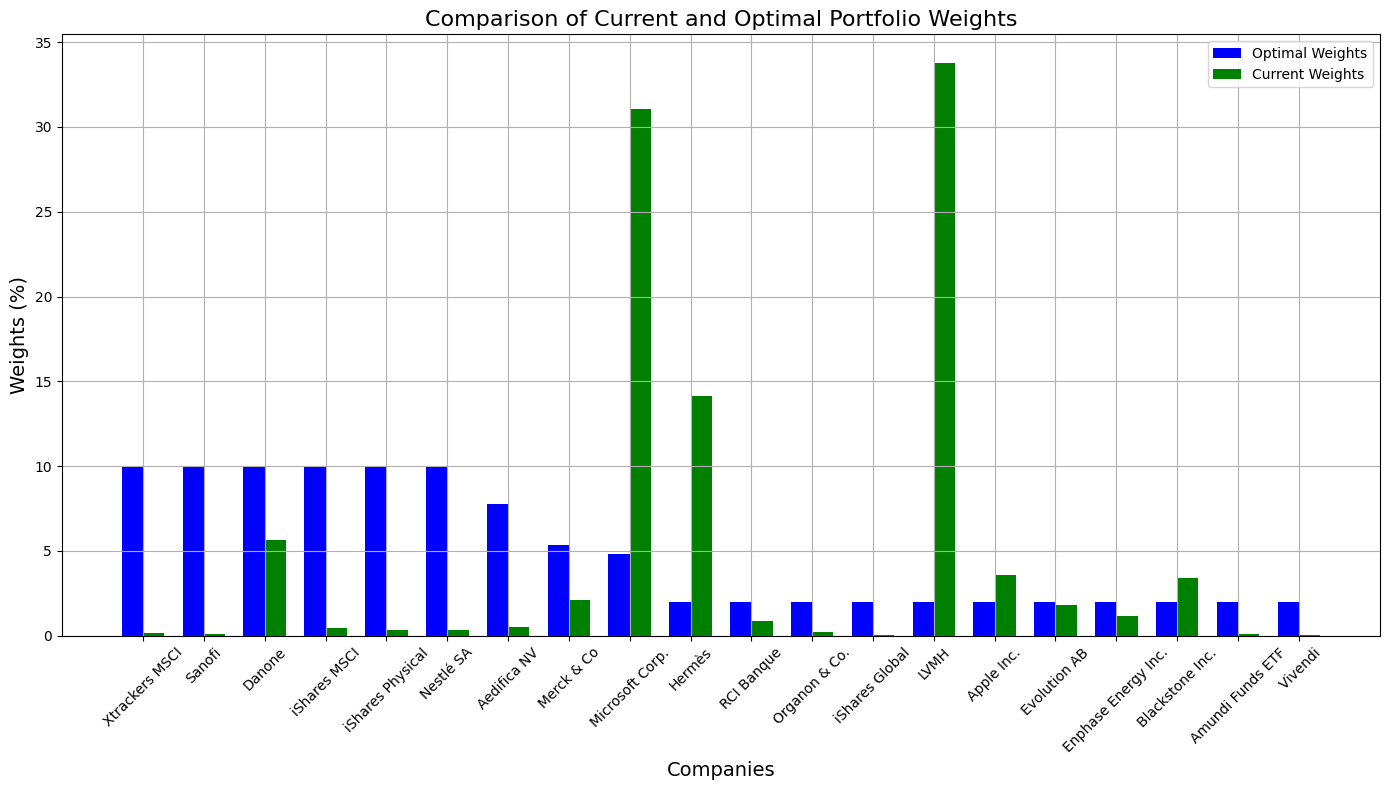

,Optimal Weights (%),Current Weights (%)
Xtrackers MSCI,10.00,0.19
Sanofi,10.00,0.12
Danone,10.00,5.67
iShares MSCI,10.00,0.45
iShares Physical,10.00,0.32
Nestlé SA,10.00,0.32
Aedifica NV,7.79,0.52
Merck & Co,5.38,2.11
Microsoft Corp.,4.84,31.07
Hermès,2.00,14.16


In [34]:
ticker_to_name = {
    "SAN.PA": "Sanofi",
    "VIV.PA": " Vivendi",
    "RMS.PA": "Hermès",
    "BN.PA": "Danone",
    "2B78.DE": "Xtrackers MSCI Emerging Markets ESG",
    "AAPL": "Apple Inc.",
    "AED.BR": "Aedifica NV",
    "BFIT.AS": "Amundi Funds Global Fit ETF",
    "BX": "Blackstone Inc.",
    "EVO.ST": "Evolution AB",
    "ENPH": "Enphase Energy Inc.",
    "IGLN.L": "iShares Physical Gold ETC",
    "IESE.AS": "iShares MSCI Europe SRI ETF",
    "IQQH.DE": "iShares Global Clean Energy ETF",
    "MC.PA": "LVMH Moët Hennessy Louis Vuitton",
    "MRK": "Merck & Co., Inc.",
    "MSFT": "Microsoft Corp.",
    "NESN.SW": "Nestlé SA",
    "OGN": "Organon & Co.",
    "RCF.F": "RCI Banque",
}
ticker_to_name_reduced = {
    "SAN.PA": "Sanofi",
    "VIV.PA": " Vivendi",
    "RMS.PA": "Hermès",
    "BN.PA": "Danone",
    "2B78.DE": "Xtrackers MSCI",
    "AAPL": "Apple Inc.",
    "AED.BR": "Aedifica NV",
    "BFIT.AS": "Amundi Funds ETF",
    "BX": "Blackstone Inc.",
    "EVO.ST": "Evolution AB",
    "ENPH": "Enphase Energy Inc.",
    "IGLN.L": "iShares Physical",
    "IESE.AS": "iShares MSCI",
    "IQQH.DE": "iShares Global",
    "MC.PA": "LVMH",
    "MRK": "Merck & Co",
    "MSFT": "Microsoft Corp.",
    "NESN.SW": "Nestlé SA",
    "OGN": "Organon & Co.",
    "RCF.F": "RCI Banque",
}
#print(weights_optimal)
#print(current_weights)

plot_template(weights_optimal, current_weights,ticker_to_name_reduced, save_path='weights_comparison_real_name.png')

Allocation in whole shares: {'Xtrackers MSCI': 1030, 'Apple Inc.': 6, 'Aedifica NV': 104, 'Amundi Funds ETF': 74, 'Danone': 119, 'Blackstone Inc.': 8, 'Enphase Energy Inc.': 22, 'Evolution AB': 18, 'iShares MSCI': 110, 'iShares Physical': 124, 'iShares Global': 235, 'LVMH': 2, 'Merck & Co': 43, 'Microsoft Corp.': 9, 'Nestlé SA': 94, 'Organon & Co.': 106, 'RCI Banque': 18, 'Hermès': 0, 'Sanofi': 85, ' Vivendi': 183}
Remaining resources: 2632.26 EUR


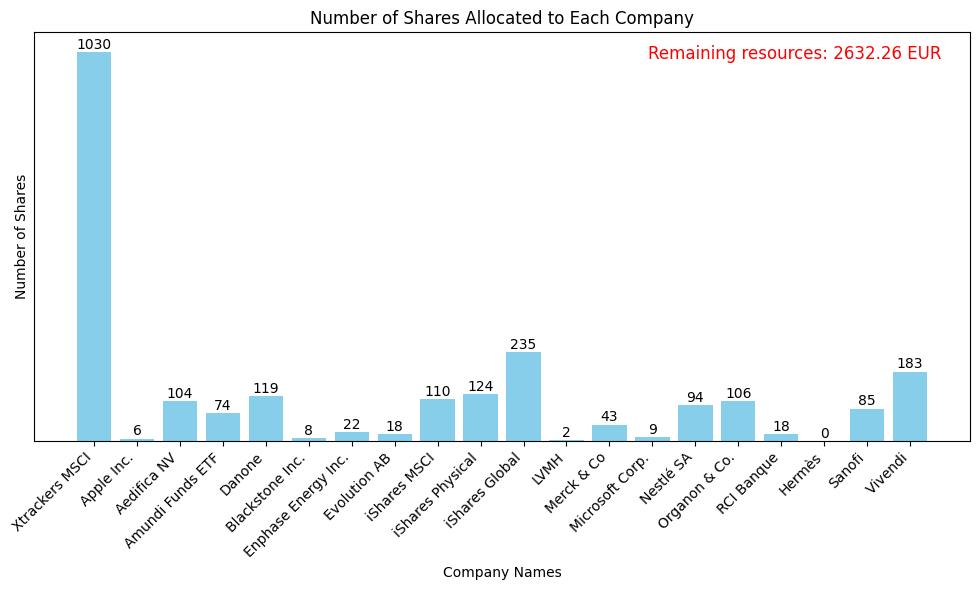

In [36]:
ticker_to_name = ticker_to_name_reduced
# Allocate euros to each asset based on optimal weights
allocation_in_euros = {
    ticker_to_name[ticker]: weight * total_portfolio_value
    for ticker, weight in weights_optimal.items()
}

# Calculate the number of whole shares to purchase for each asset
allocation_in_shares = {
    ticker_to_name[ticker]: int(allocation_in_euros[ticker_to_name[ticker]] // last_prices[ticker])
    for ticker, weight in weights_optimal.items() if allocation_in_euros[ticker_to_name[ticker]] > 0
}

# Calculate the remaining resources after allocation
used_value = sum(allocation_in_shares[company] * last_prices[ticker] 
                 for ticker, company in ticker_to_name.items() if company in allocation_in_shares)
leftover = total_portfolio_value - used_value

# Display the results
print("Allocation in whole shares:", allocation_in_shares)
print("Remaining resources:", round(leftover, 2), "EUR")

# Plotting the number of shares for each stock
plt.figure(figsize=(10, 6))
bars = plt.bar(allocation_in_shares.keys(), allocation_in_shares.values(), color='skyblue')

# Adding the number of shares on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5,  # Position the text slightly above the bar
             str(int(yval)), ha='center', va='bottom', fontsize=10)

# Removing the y-axis labels
plt.yticks([])

# Adding labels and title
plt.xlabel('Company Names')
plt.ylabel('Number of Shares')
plt.title('Number of Shares Allocated to Each Company')

# Add the remaining resources in the top right corner
plt.text(0.97, 0.97, f'Remaining resources: {round(leftover, 2)} EUR', 
         ha='right', va='top', fontsize=12, color='red', transform=plt.gca().transAxes)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('shares_allocation.png')
plt.show()